In [1]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels
from ml_helpers import training

# Read data

# COLMAP integration

# Camera / Dataset

In [21]:
batch_size = 1024

o, d, target_px_values= get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                   torch.from_numpy(d).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)

dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)






class TruncExp(torch.autograd.Function):
    @staticmethod
    @custom_fwd(cast_inputs=torch.float32)
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.exp(x)

    @staticmethod
    @custom_bwd
    def backward(ctx, dL_dout):
        x = ctx.saved_tensors[0]
        return dL_dout * torch.exp(x.clamp(-15, 15))


test_o, test_d, test_target_px_values= get_rays('fox', mode='test')

NameError: name 'custom_fwd' is not defined

In [3]:
test_o.shape

(10, 160000, 3)

# Model

In [4]:
model = Voxels(scale=3)

In [8]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [9]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

NameError: name 'img' is not defined

# Training

In [22]:
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


In [36]:
# CPU WORKING

'''
device = 'cpu'

tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = .5
nb_bins = 100

model = Voxels(scale=3, device=device).to(torch.float32) #Apple sillicon float32
#model = Voxels(scale=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)


training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
'''

  0%|                                                                 | 0/14063 [00:00<?, ?it/s]


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

100%|█████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 51.91it/s]


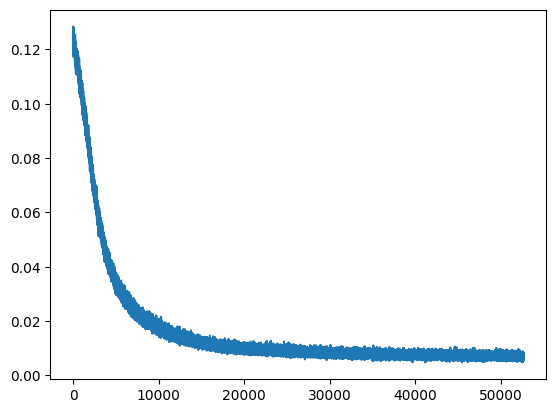

In [23]:
# APPLE SILLICON 
# ml_helpers transformation float32 2 float64

device = 'mps'

tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = .5
nb_bins = 100

model = Voxels(scale=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader_warmup, device=device)
plt.plot(training_loss)
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

In [24]:
img = rendering(model, 
                torch.from_numpy(o[1]).to(torch.float32).to(device),  # Convert after tensor creation
                torch.from_numpy(d[1]).to(torch.float32).to(device), 
                tn, tf, nb_bins=100, device=device)

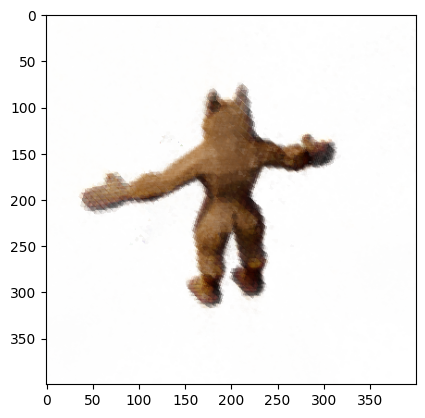

In [25]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

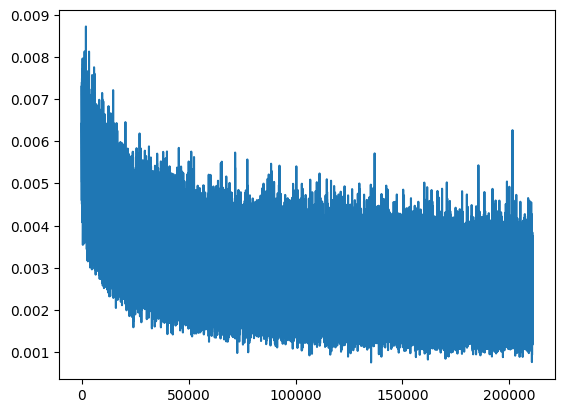

In [27]:
plt.plot(training_loss)
torch.save(model, 'model_voxels')

# Rendering